# 텍스트 요약(  Text Summarization with Attention mechanism )

- 텍스트 요약은 상대적으로 큰 원문을 핵심 내용만 간추려서 상대적으로 적은 요약문으로 변환하는 것을 말한다.

## 텍스트 요약(  Text Summarization )

### 1) 추출적 요약(  extractive summarization )

- 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법으로 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들이다.
- 추축적 요약의 대표적인 알고리즘으로 ML 알고리즘인 텍스트랭크( TextRank )가 있는데 다음의 링크에서 텍스트 랭크로 구현된 세 줄 요약기를 시험해 볼 수 있다.

https://summariz3.herokuapp.com/

### 2) 추상적 요약(  abstractive summarization )

- 원문에 없던 문장이라도 핵심 문맥을 반영한 새로운 문장을 생성해서 원문을 요약하는 방법으로 마치 사람이 요약하는 것 같은 방식이다.
- 추출적 요약보다는 난이도가 높으며 이 방법은 주로 인공 신경망을 사용하며 대표적인 모델로 seq2seq가 있다. 
- 이 방법의 단점이라면 seq2seq와 같은 인공 신경망들은 기본적으로 지도 학습이라는 점으로 추상적 요약을 인공 신경망으로 훈련하기 위해서는 '원문' 뿐만 아니라 '실제 요약문'이라는 레이블 데이터가 있어야 하므로 데이터를 구성하는 것 자체가 하나의 부담이다. 

## 아마존 리뷰 데이터에 대한 이해

https://www.kaggle.com/snap/amazon-fine-food-reviews

In [0]:
import re
from bs4 import BeautifulSoup 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 1) 데이터 로드

In [2]:
# Reviews.csv 파일을 data라는 이름의 데이터프레임에 저장. 단, 10만개의 행(rows)으로 제한.
data = pd.read_csv("Reviews.csv", nrows = 100000)
print('전체 리뷰 개수 :',(len(data)))

전체 리뷰 개수 : 6263


In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data = data[['Text','Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [5]:
# 랜덤으로 10개의 샘플 출력
data.sample(10)

,Text,Summary
2328,Sweetarts evokes nostalgic memories of going i...,Classic Candy
2036,"Great mixed for Belgium waffles, family thinks...",great stuff
4759,Just signed up for the Subscribe and Save opti...,Subscribe and Save option is a good deal
3813,Just received these boxes rather than buying t...,Panda boxes of little licorice pieces
3074,If your not into healthy and into flax seed DO...,Good if you like flax seed.
1056,"Riba foods based in Houston, Texas makes this ...",Great fat free and spicy!!!
4840,I adopted a dog from rescue shelter who has an...,For Dogs with special needs
5988,The first batch I got must have been a bad bat...,"Good coffee, with some exceptions."
3477,Super good price and the best k cup cocoa we h...,Great cocoa !!
1380,If you are looking for a sweetener that is del...,Also look for the packets


### 2) 데이터 정제

In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 6239
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 5672


In [0]:
# text 열에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['Text'], inplace=True)

In [8]:
print(data.isnull().sum())

Text       1
Summary    0
dtype: int64


In [9]:
# Null 값을 가진 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 6239


In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
# 전처리 함수 내 사용 - 단어 정규화/불용어 처리
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [13]:
# NLTK의 불용어
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'have', 'he', "hadn't", 'wouldn', 'once', 'each', 'during', "mightn't", 've', 'did', 'our', "she's", 'but', 'off', 'against', 'few', 'm', 'between', 'are', 'through', 'at', 'be', 'then', 's', 'hers', 'ain', 'we', 'themselves', 'needn', "hasn't", 'below', "that'll", 'were', 'some', "needn't", 'him', 'which', 'yourselves', 'until', 'weren', 'wasn', 'don', 'own', 'ma', 'y', 'ourselves', 'aren', 'it', 'as', 'them', 'all', 'had', 'very', 'than', 'my', 'its', 'by', 'herself', 'was', 'over', 'more', 'what', 'you', 'been', 'their', 'myself', 'am', 'me', 'not', 'shan', 'or', "wouldn't", 'o', 'mightn', "you'd", 'about', "wasn't", 'who', 't', 'in', 'didn', 'and', 'why', 'does', 'an', 'under', 'whom', 'having', 'these', "haven't", 'the', "shan't", 'ours', 'this', 'couldn', "should've", 'further', 'that', 'into', 'while', 'after', 'other', 'to', 'those', 'down', 'for', 'such', 'they', "aren't", 'has', 'out', 'with', 'where', 'of', 'so', 'too', 'can', "mustn't", 'won', 'now', 'his', "i

In [0]:
# 전처리 함수
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [15]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text)) # Text 열에서는 불용어를 제거
print(preprocess_sentence(temp_summary, 0)) # Summary를 입력으로 할 때는 두번째 인자를 0으로 줘서 불용어를 제거하지 않는 버전을 실행

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [16]:
# Text 열 전처리
clean_text = []
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [17]:
# Summary 열 전처리
clean_summary = []
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

['good quality dog food',
 'not as advertised',
 'delight says it all',
 'cough medicine',
 'great taffy']

In [0]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [19]:
# 길이가 공백인 샘플은 NULL 값으로 변환
data.replace('', np.nan, inplace=True)
print(data.isnull().sum())

Text       0
Summary    5
dtype: int64


In [20]:
data.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 6234


텍스트의 최소 길이 : 4
텍스트의 최대 길이 : 449
텍스트의 평균 길이 : 36.08084696823869
요약의 최소 길이 : 1
요약의 최대 길이 : 23
요약의 평균 길이 : 3.926371511068335


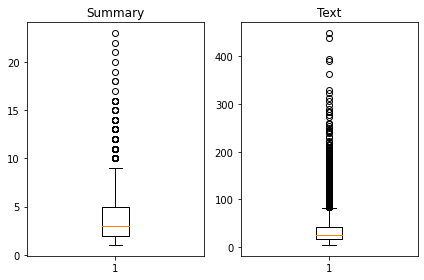

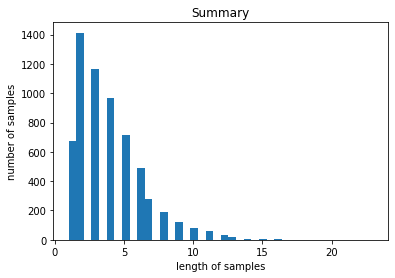

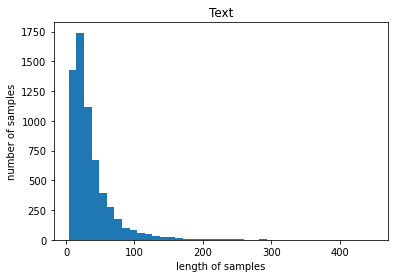

In [21]:
# 길이 분포 출력
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [0]:
text_max_len = 50
summary_max_len = 8

In [0]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [24]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.8097529675970484


In [25]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.9459416105229387


In [26]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(data)))

전체 샘플수 : 4860


In [27]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,not as advertised
2,confection around centuries light pillowy citr...,delight says it all
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [28]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['Summary'] = data['Summary'].apply(lambda x : 'sostoken '+ x + ' eostoken')
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,sostoken good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,sostoken not as advertised eostoken
2,confection around centuries light pillowy citr...,sostoken delight says it all eostoken
3,looking secret ingredient robitussin believe f...,sostoken cough medicine eostoken
4,great taffy great price wide assortment yummy ...,sostoken great taffy eostoken


In [0]:
Text_data = list(data['Text'])
Summary_data = list(data['Summary'])

### 3) 데이터 분리

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Text_data, Summary_data, test_size=0.2, random_state=0, shuffle=True)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 3888
훈련 레이블의 개수 : 3888
테스트 데이터의 개수 : 972
테스트 레이블의 개수 : 972


### 4) 정수 인코딩

In [0]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(X_train)

In [32]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 8772
등장 빈도가 6번 이하인 희귀 단어의 수: 6886
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 1886
단어 집합에서 희귀 단어의 비율: 78.49977200182398
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 13.973399386139679


In [0]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(X_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
X_train = src_tokenizer.texts_to_sequences(X_train) 
X_test = src_tokenizer.texts_to_sequences(X_test)

In [34]:
print(X_train[:5])

[[181, 40, 1887, 153, 22, 92, 132, 11, 3, 351, 7], [871, 49, 213, 24, 7, 957, 2128, 145, 1579, 4713, 145, 6, 1888, 427, 846, 1702, 3452, 793, 731, 4714, 1376, 957, 2128, 793, 145, 5, 82, 352, 18, 1703, 82, 189, 9, 25, 1203, 3453, 1203, 4715, 4716, 1066], [89, 238, 958, 7, 14, 1067, 6, 230, 1204, 13, 136, 79, 58, 22, 71, 1704, 2414, 14, 32], [24, 3454, 3455, 3454, 59, 1580, 33, 3, 16, 239, 6, 21, 3456, 1205, 36, 3455, 16, 135, 654, 2129, 21, 27], [5, 37, 105, 4717, 4718, 2817, 1284, 4, 3, 3, 319, 36, 93, 2, 4719, 3457, 164, 2, 479, 111, 370, 82, 68, 199, 114, 90, 226, 265, 303, 1705, 822, 1068, 914, 1132, 3458, 34, 1581, 1132, 111, 83, 93, 34, 794, 1069, 847, 277, 1377, 3459]]


In [0]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(y_train)

In [36]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 2400
등장 빈도가 5번 이하인 희귀 단어의 수: 2048
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 352
단어 집합에서 희귀 단어의 비율: 85.33333333333334
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 16.296756911891322


In [0]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
y_train = tar_tokenizer.texts_to_sequences(y_train) 
y_test = tar_tokenizer.texts_to_sequences(y_test) 

In [38]:
print(y_train[:5])

[[1, 3, 116, 1096, 47, 2], [1, 1097, 421, 2], [1, 25, 159, 2], [1, 4, 31, 2], [1, 12, 52, 47, 2]]


### 5) 빈 샘플( empty samples ) 제거

In [0]:
drop_train = [index for index, sentence in enumerate(y_train) if len(sentence) == 2]
drop_test = [index for index, sentence in enumerate(y_test) if len(sentence) == 2]

In [40]:
print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 3888
훈련 레이블의 개수 : 3888
테스트 데이터의 개수 : 972
테스트 레이블의 개수 : 972


In [41]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
X_test = np.delete(X_test, drop_test, axis=0)
y_test = np.delete(y_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(X_train))
print('훈련 레이블의 개수 :',len(y_train))
print('테스트 데이터의 개수 :',len(X_test))
print('테스트 레이블의 개수 :',len(y_test))

훈련 데이터의 개수 : 3851
훈련 레이블의 개수 : 3851
테스트 데이터의 개수 : 948
테스트 레이블의 개수 : 948


### 6) 패딩

In [0]:
X_train = pad_sequences(X_train, maxlen = text_max_len, padding='post')
X_test = pad_sequences(X_test, maxlen = text_max_len, padding='post')
y_train = pad_sequences(y_train, maxlen = summary_max_len, padding='post')
y_test = pad_sequences(y_test, maxlen = summary_max_len, padding='post')

### 7) seq2seq + attention 사용 요약 모델 설계 및 훈련

In [0]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [0]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [0]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb = Embedding(tar_vocab, embedding_dim)(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

#### seq2seq이용 출력층

In [46]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

####  attention이용 출력층

- 어텐션 함수를 직접 작성하지 않고 이미 깃허브에 공개된 함수 사용
- attention.py 파일을 다운로드하고, AttentionLayer를 임포트

In [0]:
import urllib.request

urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [48]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [0]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [50]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit([X_train, y_train[:,:-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,1:] \
                  ,epochs=50, callbacks=[es], batch_size = 256, validation_data=([X_test, y_test[:,:-1]], \
                  y_test.reshape(y_test.shape[0], y_test.shape[1], 1)[:,1:]))

Epoch 1/50
16/16 [==============================] - 79s 5s/step - loss: 4.3867 - val_loss: 3.3990
Epoch 2/50
16/16 [==============================] - 77s 5s/step - loss: 3.4873 - val_loss: 3.1099
Epoch 3/50
16/16 [==============================] - 77s 5s/step - loss: 3.2416 - val_loss: 2.8832
Epoch 4/50
16/16 [==============================] - 77s 5s/step - loss: 3.1391 - val_loss: 2.8246
Epoch 5/50
16/16 [==============================] - 77s 5s/step - loss: 3.0962 - val_loss: 2.8420
Epoch 6/50
16/16 [==============================] - 77s 5s/step - loss: 2.9880 - val_loss: 2.7107
Epoch 7/50
16/16 [==============================] - 77s 5s/step - loss: 2.8921 - val_loss: 2.7015
Epoch 8/50
16/16 [==============================] - 81s 5s/step - loss: 2.8686 - val_loss: 2.6673
Epoch 9/50
16/16 [==============================] - 76s 5s/step - loss: 2.8248 - val_loss: 2.6839
Epoch 10/50
16/16 [==============================] - 77s 5s/step - loss: 2.7594 - val_loss: 2.6604
Epoch 11/50
16/16 [

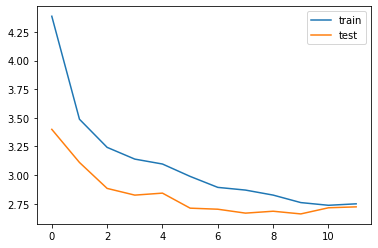

In [51]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 8) seq2seq + attention으로 요약 모델 테스트

In [0]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

### seq2seq는 훈련 단계와 테스트 단계의 동작이 다르므로 테스트 단계의 모델을 별도로 다시 설계해줄 필요가 있다. 새로운 seq2seq 모델의 인코더 정의

In [0]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [61]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2= dec_emb_layer(decoder_inputs) 
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

NameError: ignored

In [55]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

NameError: ignored

In [0]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)
    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, tar_vocab))
    target_seq[0, 0, tar_index_to_word['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""
    while not stop_condition: #stop_condition이 True가 될 때까지 루프 반복
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_tar_len):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트 합니다.
        target_seq = np.zeros((1, 1, tar_vocab))
        target_seq[0, 0, sampled_token_index] = 1.

        # 상태를 업데이트 합니다.
        states_value = [h, c]

    return decoded_sentence

In [0]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [79]:
for i in range(500, 1000):
    print("원문 : ",seq2text(X_test[i]))
    print("실제 요약문 :",seq2summary(y_test[i]))
    print("예측 요약문 :",decode_sequence(X_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  chips awesome first bought costco cannot get bags costco times larger one recieved amazon arrived mostly tiny crumbles chips bags full waste money buying amazon shipping par find chips retail would buying way website says super target costco carries able find recently 
실제 요약문 : great chips but terrible shipping 


KeyError: ignored